In [3]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(mltools)
library(MLmetrics)
library(nnet)
library(class)
library(MASS)
library(caret)
library(ISLR2)
library(boot)
library(caret)
library(nnet)
library(rsample)
library(tidymodels)
library(recipes)
library(DataExplorer)
library(discrim)
library(dplyr)
library("corrplot")
library(class)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:MLmetrics’:

    MAE, RMSE


The following object is masked from 

In [4]:
test<-read.csv("/kaggle/input/forest-frenzy/test.csv")
train<-read.csv("/kaggle/input/forest-frenzy/train.csv")
sample<-("/kaggle/input/forest-frenzy/sample_submission.csv")

In [24]:
head(train)

,id,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,⋯,soil_type32,soil_type33,soil_type34,soil_type35,soil_type36,soil_type37,soil_type38,soil_type39,soil_type40,cover_type
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,A1,2840,20,6,42,6,566,216,228,149,⋯,0,0,0,0,0,0,0,0,0,2
2,A2,2690,95,11,0,0,1605,238,223,114,⋯,0,0,0,0,0,0,0,0,0,2
3,A3,2759,22,17,0,0,752,207,200,126,⋯,0,0,0,0,0,0,0,0,0,1
4,A4,3140,51,27,400,219,1981,222,172,68,⋯,0,1,0,0,0,0,0,0,0,1
5,A5,3170,29,6,30,1,1288,218,226,144,⋯,0,0,0,0,0,0,0,0,0,2
6,A6,2780,148,16,60,-3,3416,240,237,121,⋯,0,0,0,0,0,0,0,0,0,1


In [6]:
# Converting binary columns
train <- train %>% 
mutate(across(wilderness_area1:cover_type, factor)) %>%
mutate(wilderness_area = case_when(
    wilderness_area1 == 1 ~ 1,
    wilderness_area2 == 1 ~ 2,
    wilderness_area3 == 1 ~ 3,
    wilderness_area4 == 1 ~ 4
  )) %>% 
mutate(soil_type = case_when(
    soil_type1 == 1 ~ 1,
    soil_type2 == 1 ~ 2,
    soil_type3 == 1 ~ 3,
    soil_type4 == 1 ~ 4,
    soil_type5 == 1 ~ 5,
    soil_type6 == 1 ~ 6,
    soil_type7 == 1 ~ 7,
    soil_type8 == 1 ~ 8,
    soil_type9 == 1 ~ 9,
    soil_type10 == 1 ~ 10,
    soil_type11 == 1 ~ 11,
    soil_type12 == 1 ~ 12,
    soil_type13 == 1 ~ 13,
    soil_type14 == 1 ~ 14,
    soil_type15 == 1 ~ 15,
    soil_type16 == 1 ~ 16,
    soil_type17 == 1 ~ 17,
    soil_type18 == 1 ~ 18,
    soil_type19 == 1 ~ 19,
    soil_type20 == 1 ~ 20,
    soil_type21 == 1 ~ 21,
    soil_type22 == 1 ~ 22,
    soil_type23 == 1 ~ 23,
    soil_type24 == 1 ~ 24,
    soil_type25 == 1 ~ 25,
    soil_type26 == 1 ~ 26,
    soil_type27 == 1 ~ 27,
    soil_type28 == 1 ~ 28,
    soil_type29 == 1 ~ 29,
    soil_type30 == 1 ~ 30,
    soil_type31 == 1 ~ 31,
    soil_type32 == 1 ~ 32,
    soil_type33 == 1 ~ 33,
    soil_type34 == 1 ~ 34,
    soil_type35 == 1 ~ 35,
    soil_type36 == 1 ~ 36,
    soil_type37 == 1 ~ 37,
    soil_type38 == 1 ~ 38,
    soil_type39 == 1 ~ 39,
    soil_type40 == 1 ~ 40
  )) 

# Converting soil and wildnerness to factor
train$soil_type <- as.factor(train$soil_type)
train$wilderness_area <- as.factor(train$wilderness_area)

# Combining distance to hydrology into total distance
train <- train %>%
  mutate(
    distance_to_hydro = horizontal_distance_to_hydrology + vertical_distance_to_hydrology,
  ) 

In [7]:
# same for test

# Converting binary columns
test <- test %>% 
mutate(across(wilderness_area1:soil_type40, factor)) %>%
mutate(wilderness_area = case_when(
    wilderness_area1 == 1 ~ 1,
    wilderness_area2 == 1 ~ 2,
    wilderness_area3 == 1 ~ 3,
    wilderness_area4 == 1 ~ 4
  )) %>% 
mutate(soil_type = case_when(
    soil_type1 == 1 ~ 1,
    soil_type2 == 1 ~ 2,
    soil_type3 == 1 ~ 3,
    soil_type4 == 1 ~ 4,
    soil_type5 == 1 ~ 5,
    soil_type6 == 1 ~ 6,
    soil_type7 == 1 ~ 7,
    soil_type8 == 1 ~ 8,
    soil_type9 == 1 ~ 9,
    soil_type10 == 1 ~ 10,
    soil_type11 == 1 ~ 11,
    soil_type12 == 1 ~ 12,
    soil_type13 == 1 ~ 13,
    soil_type14 == 1 ~ 14,
    soil_type15 == 1 ~ 15,
    soil_type16 == 1 ~ 16,
    soil_type17 == 1 ~ 17,
    soil_type18 == 1 ~ 18,
    soil_type19 == 1 ~ 19,
    soil_type20 == 1 ~ 20,
    soil_type21 == 1 ~ 21,
    soil_type22 == 1 ~ 22,
    soil_type23 == 1 ~ 23,
    soil_type24 == 1 ~ 24,
    soil_type25 == 1 ~ 25,
    soil_type26 == 1 ~ 26,
    soil_type27 == 1 ~ 27,
    soil_type28 == 1 ~ 28,
    soil_type29 == 1 ~ 29,
    soil_type30 == 1 ~ 30,
    soil_type31 == 1 ~ 31,
    soil_type32 == 1 ~ 32,
    soil_type33 == 1 ~ 33,
    soil_type34 == 1 ~ 34,
    soil_type35 == 1 ~ 35,
    soil_type36 == 1 ~ 36,
    soil_type37 == 1 ~ 37,
    soil_type38 == 1 ~ 38,
    soil_type39 == 1 ~ 39,
    soil_type40 == 1 ~ 40
  )) 

# Converting soil and wildnerness to factor
test$soil_type <- as.factor(test$soil_type)
test$wilderness_area <- as.factor(test$wilderness_area)

# Combining distance to hydrology into total distance
test <- test %>%
  mutate(
    distance_to_hydro = horizontal_distance_to_hydrology + vertical_distance_to_hydrology,
  ) 

I had seen other classmates use this approach for the numerous soil type columns. On my end, the soil type columns made this way were unable to be included in some of the models. It might have been easir to group soil type by 10's, keeping them as binary, which is something Ill revisit about this assignment. 

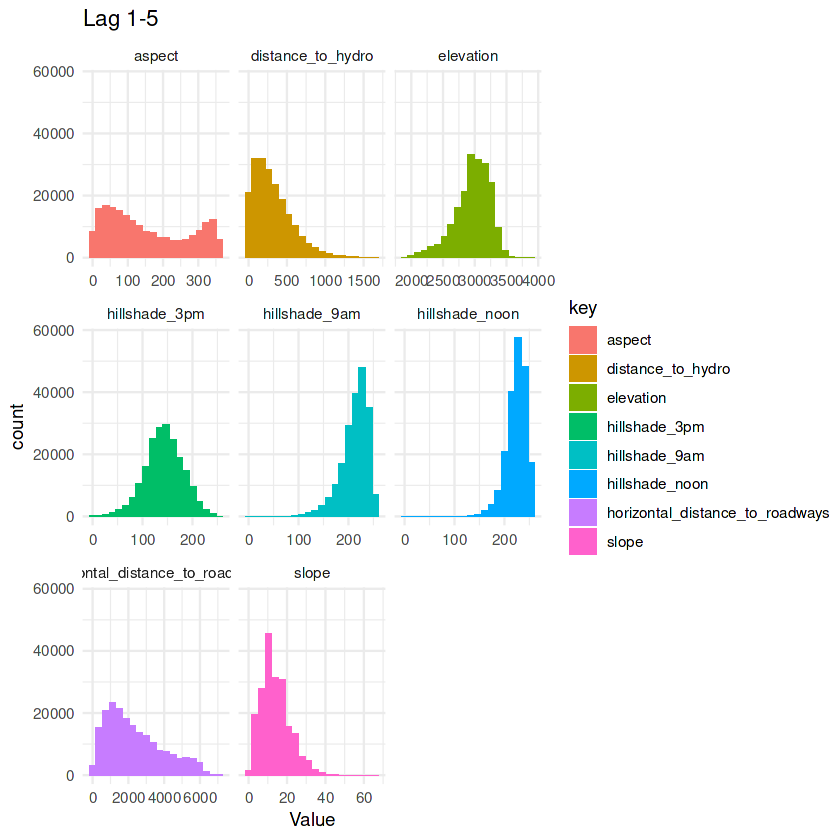

In [8]:
# Selecting columns for analysis
train1<-train[,-c(5, 6, 12:55)]

#re-ordering columns
train1<-train1[, c("id", "elevation", "aspect", "slope", "distance_to_hydro", "horizontal_distance_to_roadways", "hillshade_9am", "hillshade_noon", "hillshade_3pm", "horizontal_distance_to_fire_points", "wilderness_area", "soil_type", "cover_type")]

train_sub<-train1[, 2:9]

# Visualizing distributions of predictors to determin if gaussian
library(ggplot2)
data_long<-gather(train_sub)
ggplot(data_long, aes(x = value, fill = key)) +
  geom_histogram(position = "dodge", bins = 20) +
  facet_wrap(~ key, scales = "free_x") +
  labs(title = "Lag 1-5", x = "Value") +
  theme_minimal()

In [37]:
head(test)

,id,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,⋯,soil_type34,soil_type35,soil_type36,soil_type37,soil_type38,soil_type39,soil_type40,wilderness_area,soil_type,distance_to_hydro
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
1,A200001,3089,355,5,630,88,2144,211,230,157,⋯,0,0,0,0,0,0,0,3,32,718
2,A200002,3165,56,10,510,-29,797,227,218,124,⋯,0,0,0,0,0,0,0,2,22,481
3,A200003,3142,23,8,633,125,1674,216,223,144,⋯,0,0,0,0,0,0,0,3,31,758
4,A200004,2782,330,23,85,7,1368,158,204,182,⋯,0,0,0,0,0,0,0,3,24,92
5,A200005,2775,36,14,150,24,1316,218,208,123,⋯,0,0,0,0,0,0,0,3,32,174
6,A200006,2658,6,9,283,15,1323,210,223,151,⋯,0,0,0,0,0,0,0,1,12,298


In [9]:
# Selecting columns for analysis
test1<-test[,-c(5, 6, 12:55)]

#re-ordering columns
test1<-test1[, c("id", "elevation", "aspect", "slope", "distance_to_hydro", "horizontal_distance_to_roadways", "hillshade_9am", "hillshade_noon", "hillshade_3pm", "horizontal_distance_to_fire_points", "wilderness_area", "soil_type")]

Since some of the models assume a normal distribution, it can be seen that they might be impacted by the distributions of the predictors. Hillshade_3pm appears to have a close to gaussian distribution, but alone it might not prove as a sufficient predictor for cover_type. 

In [69]:
summary(train1)

      id              elevation        aspect          slope      
 Length:200000      Min.   :1859   Min.   :  0.0   Min.   : 0.00  
 Class :character   1st Qu.:2808   1st Qu.: 58.0   1st Qu.: 9.00  
 Mode  :character   Median :2995   Median :127.0   Median :13.00  
                    Mean   :2959   Mean   :155.4   Mean   :14.11  
                    3rd Qu.:3163   3rd Qu.:260.0   3rd Qu.:18.00  
                    Max.   :3858   Max.   :360.0   Max.   :66.00  
                                                                  
 distance_to_hydro horizontal_distance_to_roadways hillshade_9am  
 Min.   :  -3.0    Min.   :   0                    Min.   :  0.0  
 1st Qu.: 122.0    1st Qu.:1110                    1st Qu.:198.0  
 Median : 262.0    Median :1998                    Median :218.0  
 Mean   : 316.1    Mean   :2351                    Mean   :212.1  
 3rd Qu.: 451.0    3rd Qu.:3329                    3rd Qu.:231.0  
 Max.   :1651.0    Max.   :7087                    Max.   :254

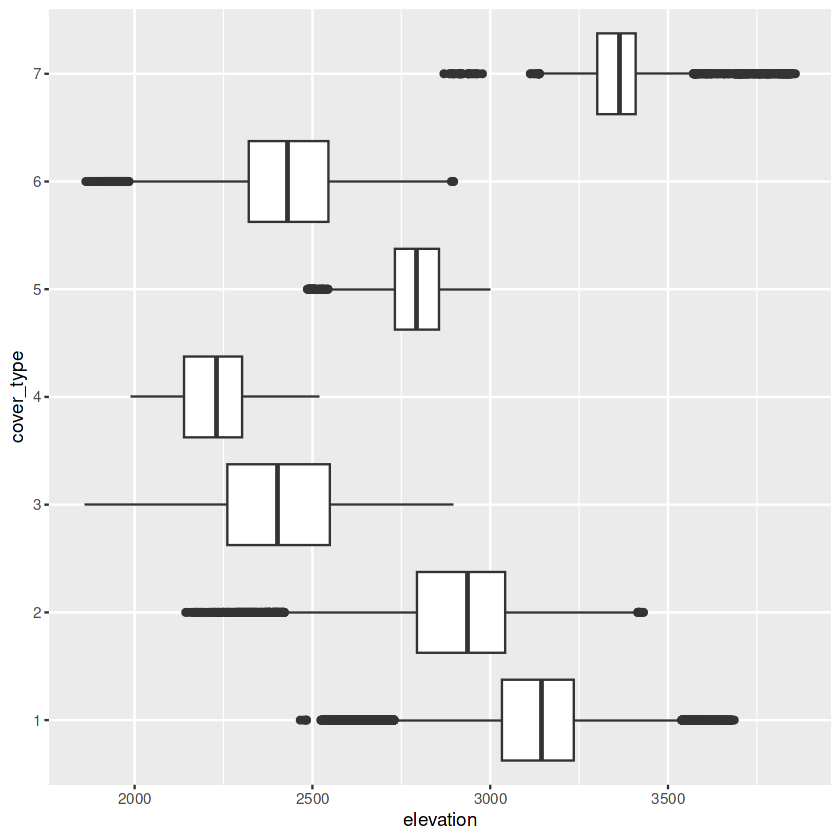

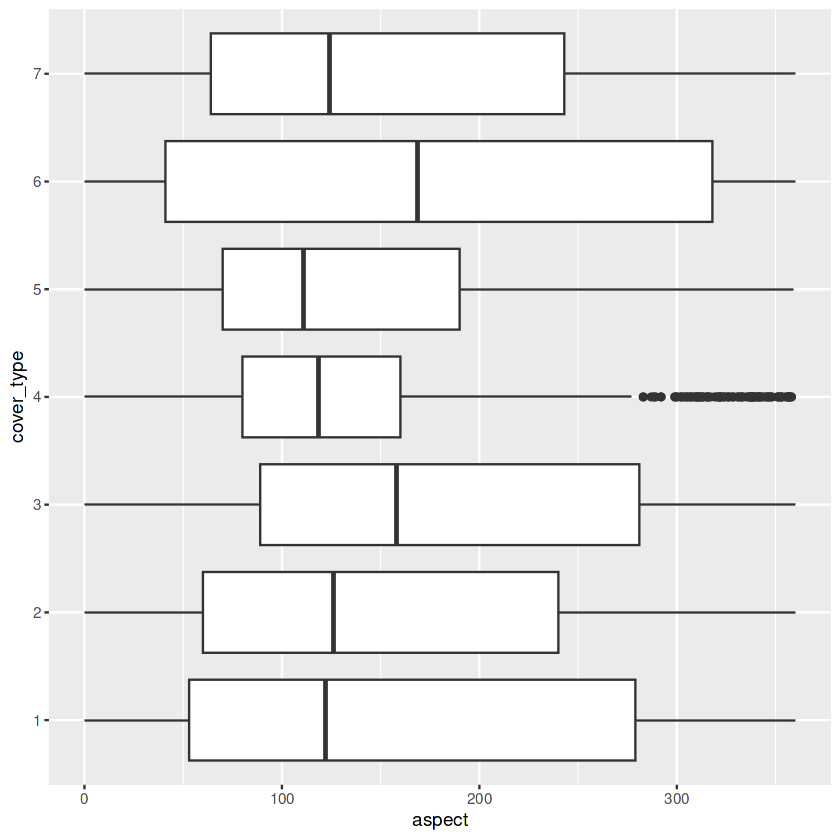

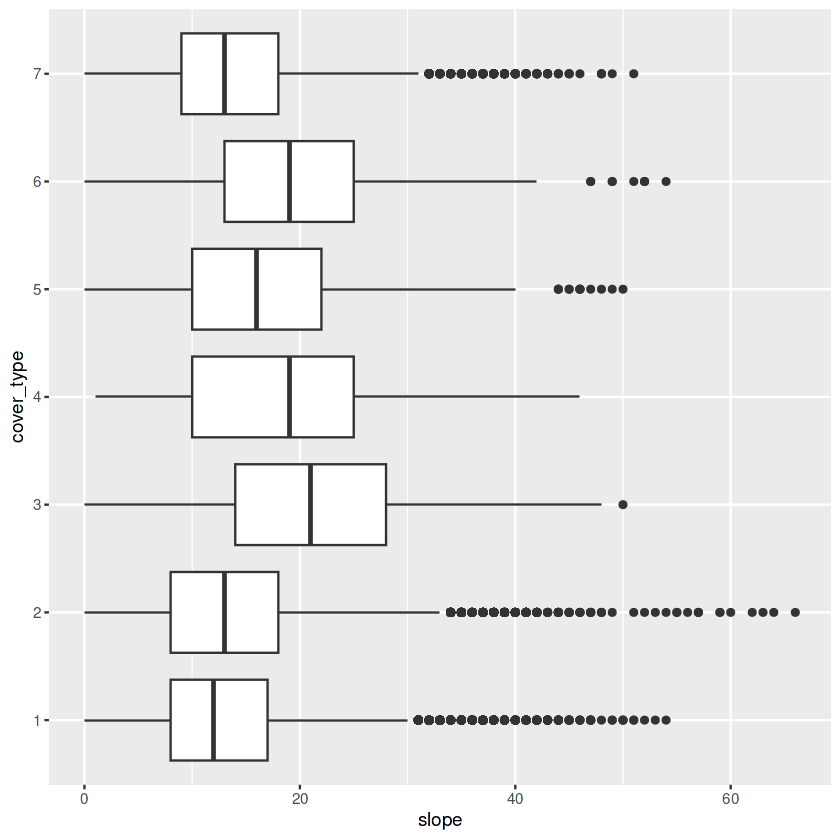

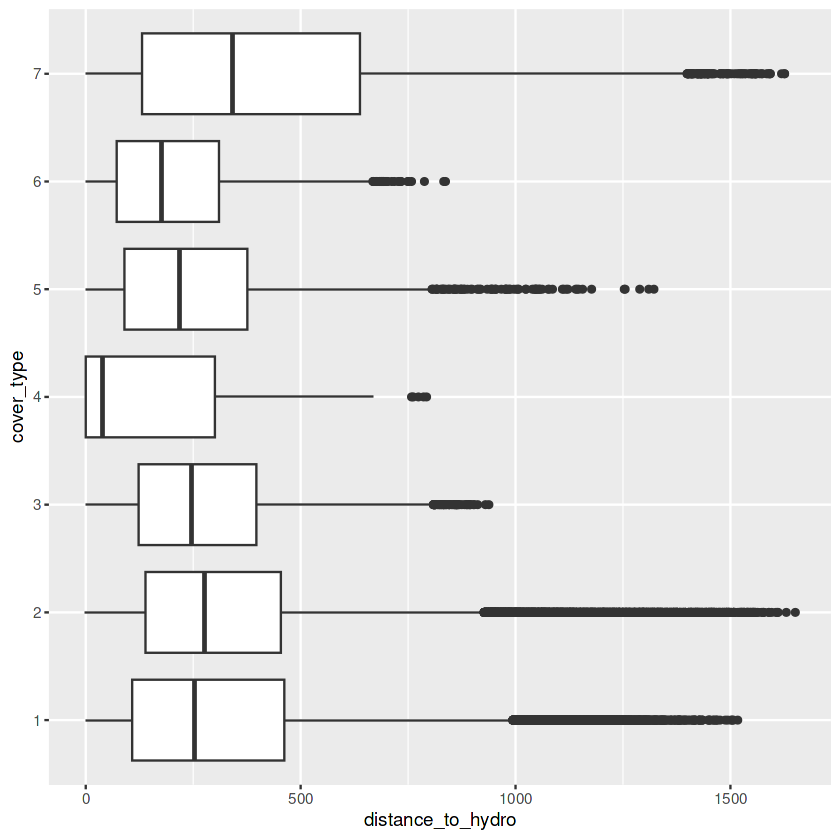

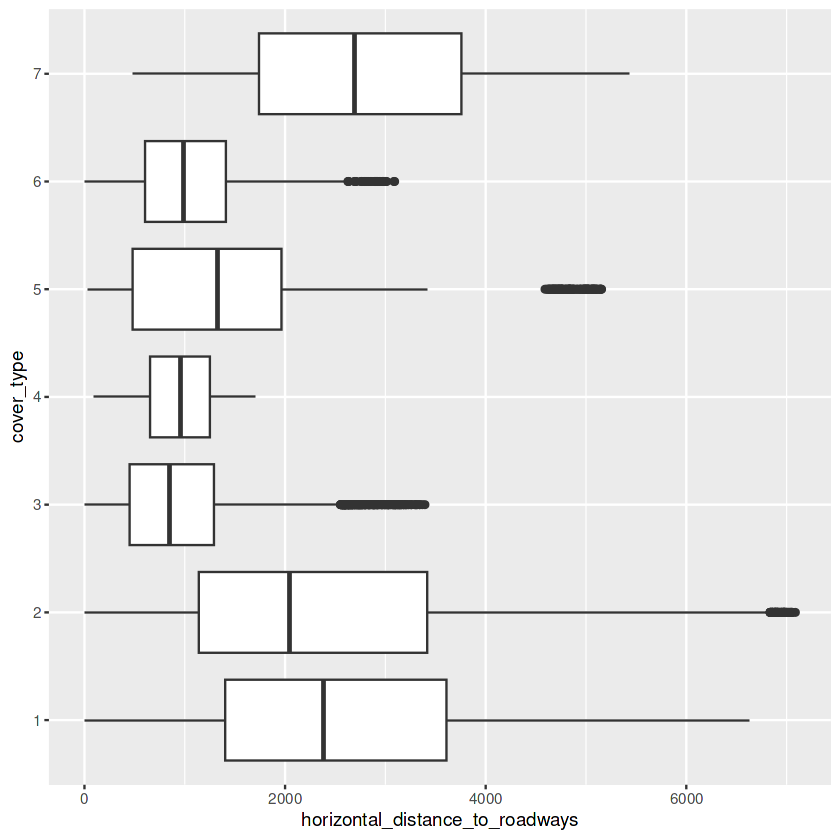

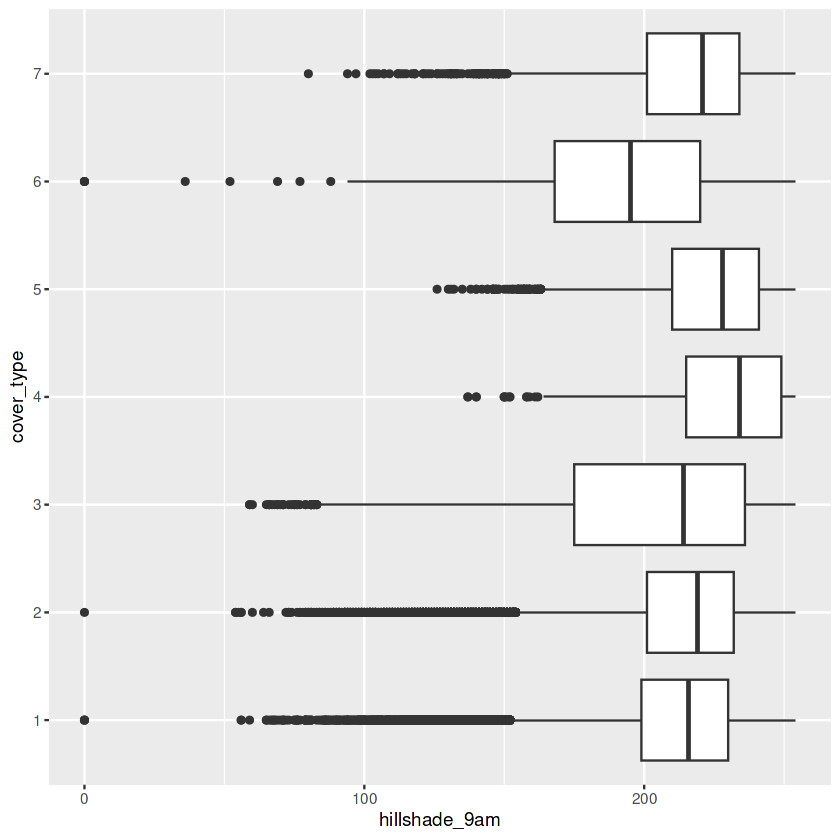

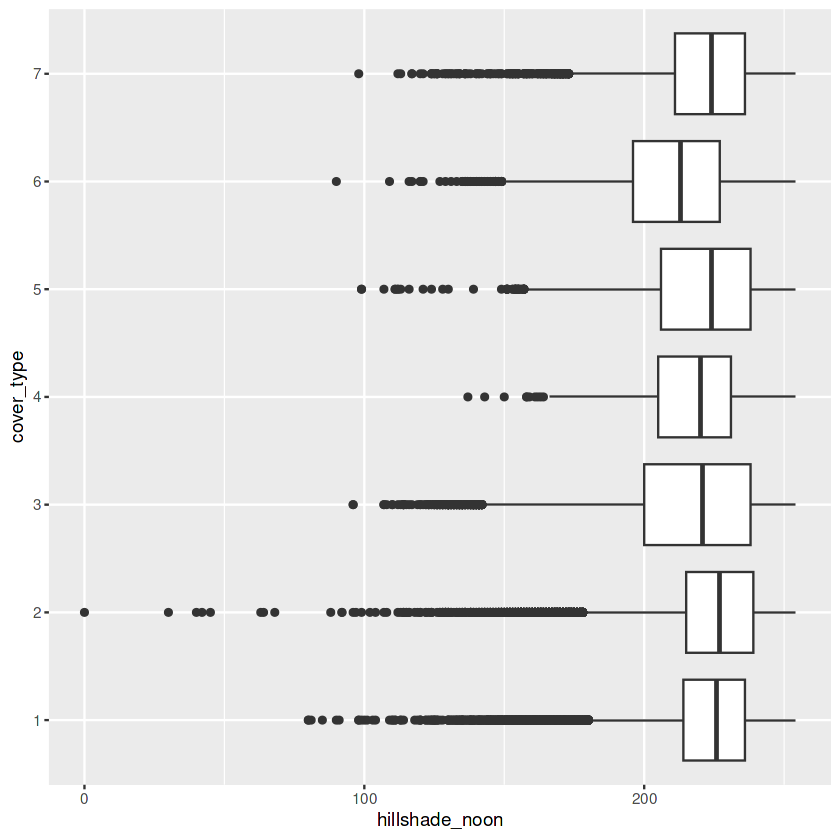

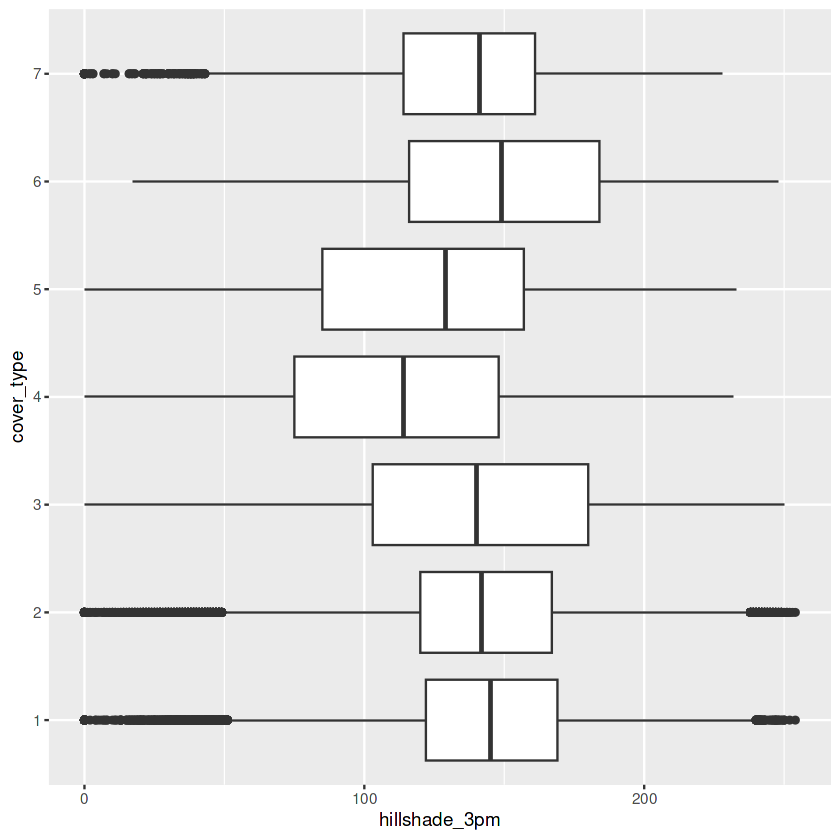

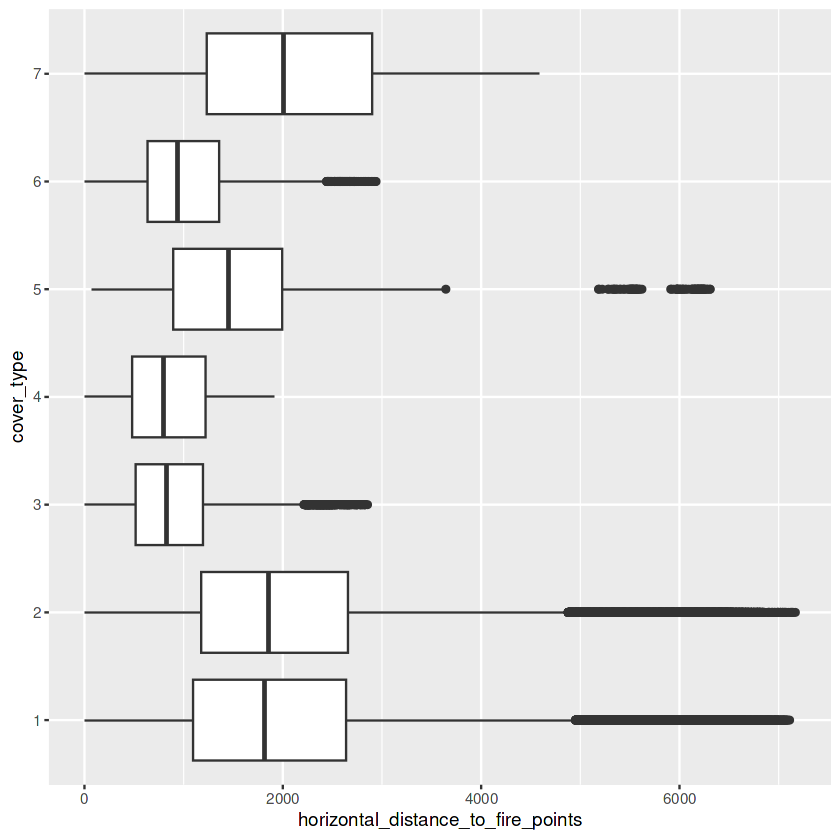

In [40]:
# box plotting predictors with outcome to determine class seperation
ggplot(data=train1, aes(x= elevation, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= aspect, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= slope, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= distance_to_hydro, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= horizontal_distance_to_roadways, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= hillshade_9am, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= hillshade_noon, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= hillshade_3pm, y= cover_type))+geom_boxplot()
ggplot(data=train1, aes(x= horizontal_distance_to_fire_points, y= cover_type))+geom_boxplot()

Based on this, it really only seems that elevation has reasonable seperation between classes in cover type. Other variables do have some spread, but there is also significant overlap with other classes.  

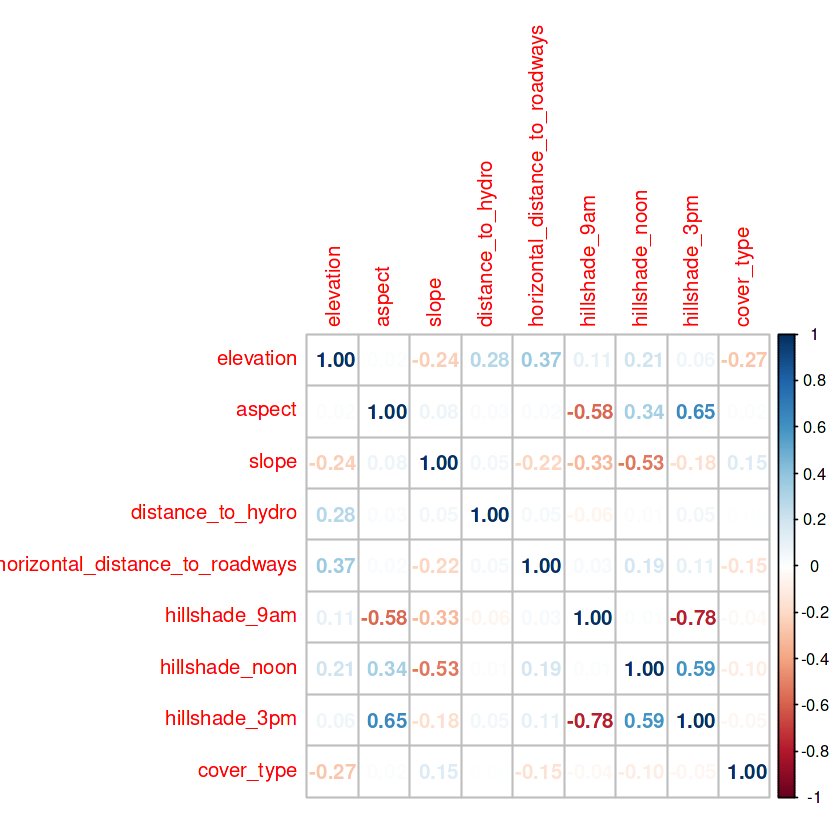

In [10]:
# Correlation Analysis
trainsub2<-train1[,c(2:9, 13)]
trainsub2$cover_type<- as.numeric(trainsub2$cover_type)
corrplot(cor(trainsub2), method= "number")

It looks like there is some correlation between variables, including hillshade, aspect. slope. Distance to hydrology had shown correlation (horizontal/ vertical), but that disappeared when the variables were combined. It's not suprising to assume that aspect, slope, and hillshade are correlated, given that they pertain to aspects of location and sunlight. 

In [42]:
# determining class proportions
class_proportions <- prop.table(table(train1$cover_type))

print("Class Proportions:")
print(class_proportions)

[1] "Class Proportions:"

       1        2        3        4        5        6        7 
0.364395 0.487165 0.061940 0.004680 0.016135 0.030390 0.035295 


The class porpotions are not even, with classes 1 and 2 showing dramatically higher propotions. This may impact some of the models

In [43]:
#determining N/A
sum(is.na(train1))

[1] 0

In [12]:
#Scaling numeric columns
scaled_columns<-scale(train1[2:9])

# replacing old columns
scaled_train<-cbind(train1[, -(2:9)], scaled_columns)

In [13]:
# same for test

#Scaling numeric columns
scaled_test_columns<-scale(test1[2:9])

# replacing old columns
scaled_test<-cbind(test1[, -(2:9)], scaled_test_columns)

In [14]:
# splitting data

set.seed(42)
ind<-sample(1:nrow(scaled_train), size = 0.7*nrow(scaled_train))
train_mod<-scaled_train[ind,]
test_mod<-scaled_train[-ind,]


# Validation
control <- trainControl(method = "cv", number = 5)

In [ ]:
head(train_mod)

In [30]:
multi_log <- train(cover_type ~ elevation + aspect + slope + horizontal_distance_to_roadways + hillshade_9am + hillshade_noon + hillshade_3pm + horizontal_distance_to_fire_points, data = train_mod, method = "multinom", trControl = control)
summary(multi_log)

# weights:  70 (54 variable)
initial  value 217941.936694 
iter  10 value 129552.503175
iter  20 value 116598.276358
iter  30 value 115762.666603
iter  40 value 101678.156627
iter  50 value 95811.100055
iter  60 value 83350.801029
iter  70 value 81982.392287
iter  80 value 81635.259109
iter  90 value 81621.446263
iter 100 value 81620.754257
final  value 81620.754257 
stopped after 100 iterations
# weights:  70 (54 variable)
initial  value 217941.936694 
iter  10 value 129553.681866
iter  20 value 116602.915563
iter  30 value 115766.745462
iter  40 value 101729.444605
iter  50 value 95984.891208
iter  60 value 83520.193947
iter  70 value 82018.083513
iter  80 value 81687.676758
iter  90 value 81676.311659
iter 100 value 81675.679682
final  value 81675.679682 
stopped after 100 iterations
# weights:  70 (54 variable)
initial  value 217941.936694 
iter  10 value 129552.504336
iter  20 value 116598.280758
iter  30 value 115762.666666
iter  40 value 101678.201349
iter  50 value 95811.084321

Call:
nnet::multinom(formula = .outcome ~ ., data = dat, decay = param$decay)

Coefficients:
  (Intercept) elevation       aspect      slope horizontal_distance_to_roadways
2   0.7643064 -2.096002 -0.008808115  0.2626010                      0.09246216
3  -5.3399546 -6.854761  0.297766962  0.6621095                      0.69471471
4 -12.5043148 -9.492136  0.361755613  0.3879705                      2.57304607
5  -2.9872696 -2.894140  0.296428146  0.5553143                     -0.61580171
6  -5.5386653 -6.565061  0.133819649  1.0500400                      0.98714614
7  -7.0188935  4.087555  0.160802353 -0.1993466                      0.18941761
  hillshade_9am hillshade_noon hillshade_3pm horizontal_distance_to_fire_points
2    -0.0116245      0.6305779    -0.2365581                       2.287999e-05
3    -0.4071302      1.7016547    -1.3605083                      -5.995845e-04
4     0.5511819      1.9219658    -1.3046880                      -1.978572e-04
5     0.1882837      0.9272

In [32]:
# Resample values
multi_log$resample

# Predictions
log_pred<-predict(multi_log, test_mod)

# actual outcome
actual<-test_mod$cover_type

#F1 Score
log_f1<-F1_Score(actual, log_pred)
print(log_f1)

Accuracy,Kappa,Resample
<dbl>,<dbl>,<chr>
0.6845714,0.4752287,Fold1
0.6869398,0.4780481,Fold3
0.6824286,0.4700809,Fold2
0.6827744,0.4714456,Fold5
0.6816071,0.4689333,Fold4


[1] 0.6689938


In [33]:
lda <- train(cover_type ~ elevation + aspect + slope + horizontal_distance_to_roadways + hillshade_9am + horizontal_distance_to_fire_points, data = train_mod, method = "lda", trControl = control)

lda$resample

lda_pred <- predict(lda, newdata = test_mod)

lda_f1 <- F1_Score(actual, lda_pred)
print(lda_f1)

Accuracy,Kappa,Resample
<dbl>,<dbl>,<chr>
0.6650238,0.4413050,Fold1
0.6638809,0.4393947,Fold2
0.6642620,0.4402006,Fold3
0.6656905,0.4416449,Fold4
0.6642143,0.4401581,Fold5


[1] 0.6604618


ERROR: Error in summary(lda)$cov: $ operator is invalid for atomic vectors


In [26]:
qda <- train(cover_type ~ elevation + aspect + slope + hillshade_noon, data = train_mod, method = "qda", trControl = control)

qda$resample

qda_pred <- predict(qda, newdata = test_mod)

qda_f1 <- F1_Score(actual, qda_pred)
print(qda_f1)

Accuracy,Kappa,Resample
<dbl>,<dbl>,<chr>
0.6705118,0.4535144,Fold1
0.6670714,0.4483239,Fold2
0.6676547,0.4494172,Fold3
0.6645714,0.4443135,Fold4
0.6694407,0.4515206,Fold5


[1] 0.6732494


In [21]:
nb<- train(cover_type ~ elevation + aspect + slope + horizontal_distance_to_roadways + hillshade_9am + hillshade_noon + hillshade_3pm, data = train_mod, method = "naive_bayes", trControl = control)

nb$resample

nb_pred <- predict(nb, newdata = test_mod)

nb_f1 <- F1_Score(actual, nb_pred)
print(nb_f1)

Accuracy,Kappa,Resample
<dbl>,<dbl>,<chr>
0.6555837,0.4415991,Fold1
0.6669762,0.4591967,Fold2
0.6639406,0.4543794,Fold3
0.6604286,0.4499473,Fold4
0.6646069,0.4541443,Fold5


[1] 0.6625247


In [ ]:
print(knn_f1)

In [16]:
knn <- train(cover_type ~ elevation + aspect + distance_to_hydro, data = train_mod, method = "knn", trControl = control)

knn$resample

# actual outcome
actual<-test_mod$cover_type

knn_pred <- predict(knn, newdata = test_mod)

knn_f1<- F1_Score(actual, knn_pred)
print(knn_f1)

Accuracy,Kappa,Resample
<dbl>,<dbl>,<chr>
0.6988322,0.5047387,Fold1
0.7022143,0.5093036,Fold4
0.7002750,0.5060568,Fold3
0.6935000,0.4959538,Fold2
0.6999286,0.5058869,Fold5


[1] 0.6859945


It may be that a non-linear approach, like knn, is best suited for this data frame. This could partially explain why knn did better. Though, I would recommend a further analysis of adding/removing variables with these models. I also think that a further wrangling and preproccessing of the soil type and wilderness area columns could help, as their inclusion in the models was problematic. 

In [ ]:
final<-train(cover_type ~ elevation + aspect + distance_to_hydro, data = train_mod, method = "knn", trControl = control)

final_outcome<-predict(final, newdata = scaled_test)

submission<- data.frame(id = test$id, final_outcome)
submission


write_csv(submission,"submission.csv")